# Autoencoder on KDD99 dataset

## Load dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
### load data and labels (normal and different attack types)

df_data = pd.read_csv("datasets/kddcup/kddcup.data_10_percent.gz", header=None)
df_labels = pd.DataFrame(df_data.iloc[:,-1])    ### last column has labels
df_data = df_data.iloc[:, :-1]  ### columns until last column

In [3]:
### read column names and types

col_names=[]
col_datatypes=[]

with open("datasets/kddcup/kddcup.names") as file:
    next(file)    ### skip first line
    for line in file:
        name, datatype = line.split(": ")
        col_names.append(name)
        col_datatypes.append(datatype.replace(".\n",""))
        
#col_names.append("labels")
        
df_data.columns = col_names
df_labels.columns = ["labels"]

In [4]:
df_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [5]:
## check integrity of the data

print(df_data.isnull().values.any())

print(df_data.isna().values.any())

False
False


### Enumerate labels to 0 and 1

In [6]:
### add new label column for normal and abnormal

df_data["label"] = np.where(df_labels["labels"].str.contains("normal"), "normal", "abnormal")

In [7]:
### number of normal and abnormal
print("number of normal:", len(np.where(df_data["label"] == "normal")[0]))
print("number of abnormal:", len(np.where(df_data["label"] == "abnormal")[0]))

number of normal: 97278
number of abnormal: 396743


In [8]:
## check in which location data is abnormal

np.where(df_data["label"] == "abnormal")

(array([   744,    745,   4049, ..., 490962, 490963, 490964]),)

In [9]:
### looks like working

print(df_data.iloc[740:750, -1])
print(df_labels.iloc[740:750, -1])


740      normal
741      normal
742      normal
743      normal
744    abnormal
745    abnormal
746      normal
747      normal
748      normal
749      normal
Name: label, dtype: object
740             normal.
741             normal.
742             normal.
743             normal.
744    buffer_overflow.
745    buffer_overflow.
746             normal.
747             normal.
748             normal.
749             normal.
Name: labels, dtype: object


In [10]:
### for each object columnin data

cols_toOneHot = df_data.select_dtypes(include='object').columns.tolist()

cols_all = df_data.columns.tolist()
cols_toNormalize = list(set(cols_all) - set(cols_toOneHot))

In [11]:
print("columns to normalize:\n%s\n" % cols_toNormalize)
print("columns to one-hot:\n%s\n" % cols_toOneHot)

columns to normalize:
['wrong_fragment', 'same_srv_rate', 'dst_host_srv_diff_host_rate', 'dst_host_diff_srv_rate', 'root_shell', 'srv_count', 'dst_host_rerror_rate', 'duration', 'is_host_login', 'num_compromised', 'num_access_files', 'dst_host_count', 'dst_bytes', 'dst_host_srv_rerror_rate', 'diff_srv_rate', 'num_root', 'srv_diff_host_rate', 'su_attempted', 'count', 'dst_host_srv_count', 'num_file_creations', 'dst_host_serror_rate', 'is_guest_login', 'num_shells', 'urgent', 'dst_host_same_srv_rate', 'srv_rerror_rate', 'dst_host_srv_serror_rate', 'dst_host_same_src_port_rate', 'rerror_rate', 'serror_rate', 'land', 'srv_serror_rate', 'logged_in', 'src_bytes', 'num_failed_logins', 'hot', 'num_outbound_cmds']

columns to one-hot:
['protocol_type', 'service', 'flag', 'label']



In [12]:
len(cols_toNormalize)

38

### Dataset preprocessing in numerical columns

In [13]:
def checkStats(df_data):
    i=0
    for col in df_data.columns.tolist():
        if col in cols_toOneHot:    ### skip if column is not numerical  ### TODO: check column type??
            i += 1
            continue

        min_ = df_data[col].values.min()
        max_ = df_data[col].values.max()
        std_ = df_data[col].values.std()

        print("column:%d min:%f max:%f std:%f" % (i, min_, max_, std_))
        i += 1

In [14]:
## before normalization

checkStats(df_data)

column:0 min:0.000000 max:58329.000000 std:707.745756
column:4 min:0.000000 max:693375640.000000 std:988217.100872
column:5 min:0.000000 max:5155468.000000 std:33039.967812
column:6 min:0.000000 max:1.000000 std:0.006673
column:7 min:0.000000 max:3.000000 std:0.134805
column:8 min:0.000000 max:3.000000 std:0.005510
column:9 min:0.000000 max:30.000000 std:0.782102
column:10 min:0.000000 max:5.000000 std:0.015520
column:11 min:0.000000 max:1.000000 std:0.355344
column:12 min:0.000000 max:884.000000 std:1.798324
column:13 min:0.000000 max:1.000000 std:0.010551
column:14 min:0.000000 max:2.000000 std:0.007793
column:15 min:0.000000 max:993.000000 std:2.012716
column:16 min:0.000000 max:28.000000 std:0.096416
column:17 min:0.000000 max:2.000000 std:0.011020
column:18 min:0.000000 max:8.000000 std:0.036482
column:19 min:0.000000 max:0.000000 std:0.000000
column:20 min:0.000000 max:0.000000 std:0.000000
column:21 min:0.000000 max:1.000000 std:0.037211
column:22 min:0.000000 max:511.000000 std

In [15]:
### normalization

for col in cols_toNormalize:
    mean = df_data[col].mean()
    std = df_data[col].std()
    
    if mean == 0 or std == 0:     ### columns 'num_outbound_cmds', 'is_host_login' has zero mean and std dev!!!
        continue
    
    df_data[col] = (df_data[col] - mean) / std

In [16]:
checkStats(df_data)

column:0 min:-0.067792 max:82.347314 std:0.999999
column:4 min:-0.003062 max:701.639257 std:0.999999
column:5 min:-0.026287 max:156.010874 std:0.999999
column:6 min:-0.006673 max:149.848105 std:0.999999
column:7 min:-0.047720 max:22.206606 std:0.999999
column:8 min:-0.002571 max:544.436553 std:0.999999
column:9 min:-0.044136 max:38.314004 std:0.999999
column:10 min:-0.009782 max:322.163534 std:0.999999
column:11 min:-0.417191 max:2.396977 std:0.999999
column:12 min:-0.005679 max:491.562521 std:0.999999
column:13 min:-0.010552 max:94.769097 std:0.999999
column:14 min:-0.004676 max:256.648346 std:0.999999
column:15 min:-0.005640 max:493.356987 std:0.999999
column:16 min:-0.011232 max:290.397364 std:0.999999
column:17 min:-0.009919 max:181.478116 std:0.999999
column:18 min:-0.027632 max:219.260455 std:0.999999
column:19 min:0.000000 max:0.000000 std:0.000000
column:20 min:0.000000 max:0.000000 std:0.000000
column:21 min:-0.037263 max:26.836488 std:0.999999
column:22 min:-1.558948 max:0.83

### One hot encoding of required columns

In [17]:
### obtain one hot encoding

df_data = pd.get_dummies(df_data, columns=cols_toOneHot)

- Check the resulting dataset

In [18]:
df_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label_abnormal,label_normal
0,-0.067792,-0.002879,0.138664,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396977,-0.005679,...,0,0,0,0,0,0,1,0,0,1
1,-0.067792,-0.002820,-0.011578,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396977,-0.005679,...,0,0,0,0,0,0,1,0,0,1
2,-0.067792,-0.002824,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396977,-0.005679,...,0,0,0,0,0,0,1,0,0,1
3,-0.067792,-0.002840,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396977,-0.005679,...,0,0,0,0,0,0,1,0,0,1
4,-0.067792,-0.002842,0.035214,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396977,-0.005679,...,0,0,0,0,0,0,1,0,0,1


In [19]:
### shape is correct

df_data.shape

(494021, 120)

In [20]:
df_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label_abnormal,label_normal
count,4.940210e+05,4.940210e+05,494021.000000,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,-1.899974e-17,7.083551e-19,0.000000,2.301255e-19,-3.518044e-17,2.098097e-18,-1.251307e-17,-7.924947e-18,-9.205021e-18,1.344796e-18,...,0.000022,0.001828,0.176120,0.000115,0.000049,0.000020,0.766040,0.000217,0.803089,0.196911
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.004719,0.042714,0.380923,0.010741,0.006970,0.004499,0.423347,0.014715,0.397665,0.397665
min,-6.779165e-02,-3.061683e-03,-0.026287,-6.673411e-03,-4.772014e-02,-2.571465e-03,-4.413587e-02,-9.782175e-03,-4.171913e-01,-5.678678e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.779165e-02,-3.016146e-03,-0.026287,-6.673411e-03,-4.772014e-02,-2.571465e-03,-4.413587e-02,-9.782175e-03,-4.171913e-01,-5.678678e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,-6.779165e-02,-2.535483e-03,-0.026287,-6.673411e-03,-4.772014e-02,-2.571465e-03,-4.413587e-02,-9.782175e-03,-4.171913e-01,-5.678678e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,-6.779165e-02,-2.017379e-03,-0.026287,-6.673411e-03,-4.772014e-02,-2.571465e-03,-4.413587e-02,-9.782175e-03,-4.171913e-01,-5.678678e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,8.234731e+01,7.016393e+02,156.010874,1.498481e+02,2.220661e+01,5.444366e+02,3.831400e+01,3.221635e+02,2.396977e+00,4.915625e+02,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
### check again

checkStats(df_data)

column:0 min:-0.067792 max:82.347314 std:0.999999
column:1 min:-0.003062 max:701.639257 std:0.999999
column:2 min:-0.026287 max:156.010874 std:0.999999
column:3 min:-0.006673 max:149.848105 std:0.999999
column:4 min:-0.047720 max:22.206606 std:0.999999
column:5 min:-0.002571 max:544.436553 std:0.999999
column:6 min:-0.044136 max:38.314004 std:0.999999
column:7 min:-0.009782 max:322.163534 std:0.999999
column:8 min:-0.417191 max:2.396977 std:0.999999
column:9 min:-0.005679 max:491.562521 std:0.999999
column:10 min:-0.010552 max:94.769097 std:0.999999
column:11 min:-0.004676 max:256.648346 std:0.999999
column:12 min:-0.005640 max:493.356987 std:0.999999
column:13 min:-0.011232 max:290.397364 std:0.999999
column:14 min:-0.009919 max:181.478116 std:0.999999
column:15 min:-0.027632 max:219.260455 std:0.999999
column:16 min:0.000000 max:0.000000 std:0.000000
column:17 min:0.000000 max:0.000000 std:0.000000
column:18 min:-0.037263 max:26.836488 std:0.999999
column:19 min:-1.558948 max:0.83845

In [22]:
## check integrity of the data again

print(df_data.isnull().values.any())

print(df_data.isna().values.any())

False
False


In [23]:
### check again
print(df_data.iloc[740:750, -1])

print(df_data.iloc[740:750, -2])

print(df_labels.iloc[740:750, -1])

740    1
741    1
742    1
743    1
744    0
745    0
746    1
747    1
748    1
749    1
Name: label_normal, dtype: uint8
740    0
741    0
742    0
743    0
744    1
745    1
746    0
747    0
748    0
749    0
Name: label_abnormal, dtype: uint8
740             normal.
741             normal.
742             normal.
743             normal.
744    buffer_overflow.
745    buffer_overflow.
746             normal.
747             normal.
748             normal.
749             normal.
Name: labels, dtype: object


## Autoencoder test

In [24]:
import numpy as np

from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import backend as K

from datetime import datetime

import matplotlib.pyplot as plt

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
x_train = df_data.values

In [26]:
from sklearn.model_selection import train_test_split


x_train, x_test = train_test_split(x_train, test_size=0.1, random_state=42)

In [27]:
print("x_train.shape:",x_train.shape)
print("x_test.shape:",x_test.shape)

x_train.shape: (444618, 120)
x_test.shape: (49403, 120)


### Model definition

In [28]:
### 

from keras.regularizers import l2

autoencoder = Sequential()

autoencoder.add(Dense(60, input_dim=120, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('tanh'))
autoencoder.add(Dense(30, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('tanh'))
autoencoder.add(Dense(10, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('tanh'))
autoencoder.add(Dense(1, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('linear'))   ####
autoencoder.add(Dense(10, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('tanh'))
autoencoder.add(Dense(30, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('tanh'))
autoencoder.add(Dense(60, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('tanh'))
autoencoder.add(Dense(120, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)))
autoencoder.add(Activation('linear'))  ####

In [29]:
def l2_loss(yTrue, yPred):
    ### ypred = T.clip(ypred, 0.0001, 0.99999) ###TODO??
    return K.sqrt((yTrue - yPred)**2)

### Model compilation

In [30]:
adam = optimizers.adam(lr=0.00005, clipnorm=1., clipvalue=0.5)  # (lr=0.0001)

sgd = optimizers.sgd(lr=0.0001, clipnorm=1., clipvalue=0.5)

rmsprop = optimizers.RMSprop(lr=0.0001, clipnorm=1., clipvalue=0.5)

In [31]:
autoencoder.compile(optimizer=adam, loss=l2_loss)

In [32]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7260      
_________________________________________________________________
activation_1 (Activation)    (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
activation_2 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
__________

In [33]:
### Tensorboard
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M")
print(timestamp)

tensorboard = TensorBoard(log_dir='./.logs/kdd99_autoencoder/{}'.format(timestamp), 
                            histogram_freq=0, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None)

2018-05-02_15:36
Instructions for updating:
Use the retry module or similar alternatives.


In [34]:
### inf loss!!! (resolved)
###

#### https://github.com/keras-team/keras/issues/1244 
### combination of linear and tanh might be problem??

"""
tried so far:
- dataset normalization in numerical columns (mean substraction and std dev division)
- defining model with "sequential"
- different optimizers 
- different loss (with "mean_squared_error" loss becomes nan)
- "relu" instead of "linear"

this resolved problem:
- to each dense layer:  kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001)
- adam = optimizers.adam(lr= 0.00001, clipnorm=1., clipvalue=0.5)

"""

### lr 0.00001, l2_loss : loss increases after a while
### lr 0.001, 'mean_squared_error': 

history = autoencoder.fit(x_train, x_train,       ### these details from paper??
               epochs=50,
               batch_size=512,
               shuffle=False,     ### already shuffled with train_test_split
               validation_data=(x_test,x_test),
               callbacks=[tensorboard],
               verbose=1)

Train on 444618 samples, validate on 49403 samples
Epoch 1/50
444618/444618 [==============================] - 7s 15us/step - loss: 0.1489 - val_loss: 0.1320
Epoch 2/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.1095 - val_loss: 0.0950
Epoch 3/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.0901 - val_loss: 0.0856
Epoch 4/50
444618/444618 [==============================] - 6s 13us/step - loss: 0.0838 - val_loss: 0.0814
Epoch 5/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.0809 - val_loss: 0.0787
Epoch 6/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.0779 - val_loss: 0.0758
Epoch 7/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.0757 - val_loss: 0.0759
Epoch 8/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.0753 - val_loss: 0.0747
Epoch 9/50
444618/444618 [==============================] - 5s 12us/step - loss: 0.0753 - val

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def plot_historyData(data, xlabel="epochs", ylabel="loss"):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

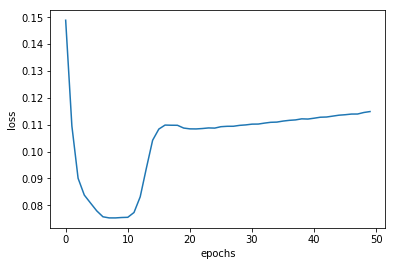

In [39]:
plot_historyData(history.history["loss"])

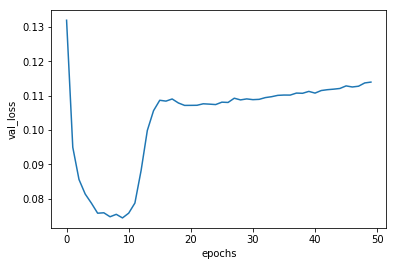

In [40]:
plot_historyData(history.history["val_loss"], ylabel="val_loss")

### Try reconstructing a normal and abnormal sample

In [44]:
### get a normal data (last column (label_normal) is one)

normal_index = np.random.choice(np.where(x_test[:, -1] == 1)[0])
print(normal_index)

### take the first abnormal data (last column (label_normal) is zero)

abnormal_index = np.random.choice(np.where(x_test[:, -1] == 0)[0])
print(abnormal_index)

30763
48205


In [45]:
## normal

normal_data = x_test[normal_index].reshape(1, -1)

normal_pred = autoencoder.predict(normal_data)

### l2 distance between input and reconstruction

np.sum(np.sqrt((normal_data - normal_pred)**2))

19.85232086131181

In [46]:
## abnormal

abnormal_data = x_test[abnormal_index].reshape(1, -1)

abnormal_pred = autoencoder.predict(abnormal_data)

### l2 distance between input and reconstruction

np.sum(np.sqrt((abnormal_data - abnormal_pred)**2))

0.22225562592926568

In [ ]:
### TODO: model save